In [1]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
# import dill as pickle4
import pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import pickle


# !pip install -q torchsummary --user
# from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"device: {device}")

device: cuda


In [2]:
import resnet18_funcs as rnf
from tqdm.notebook import trange,tqdm

device: cuda


In [3]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101);

In [4]:
path = "C:\\Users\\hanna\\Documents\\EPA\\scriptie\\planet-understanding-the-amazon-from-space\\"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")

In [5]:
path_class = os.path.join(path, "train_v2.csv/train_v2.csv")
df_class = pd.read_csv(path_class)

In [6]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

In [9]:
fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.show()

In [10]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

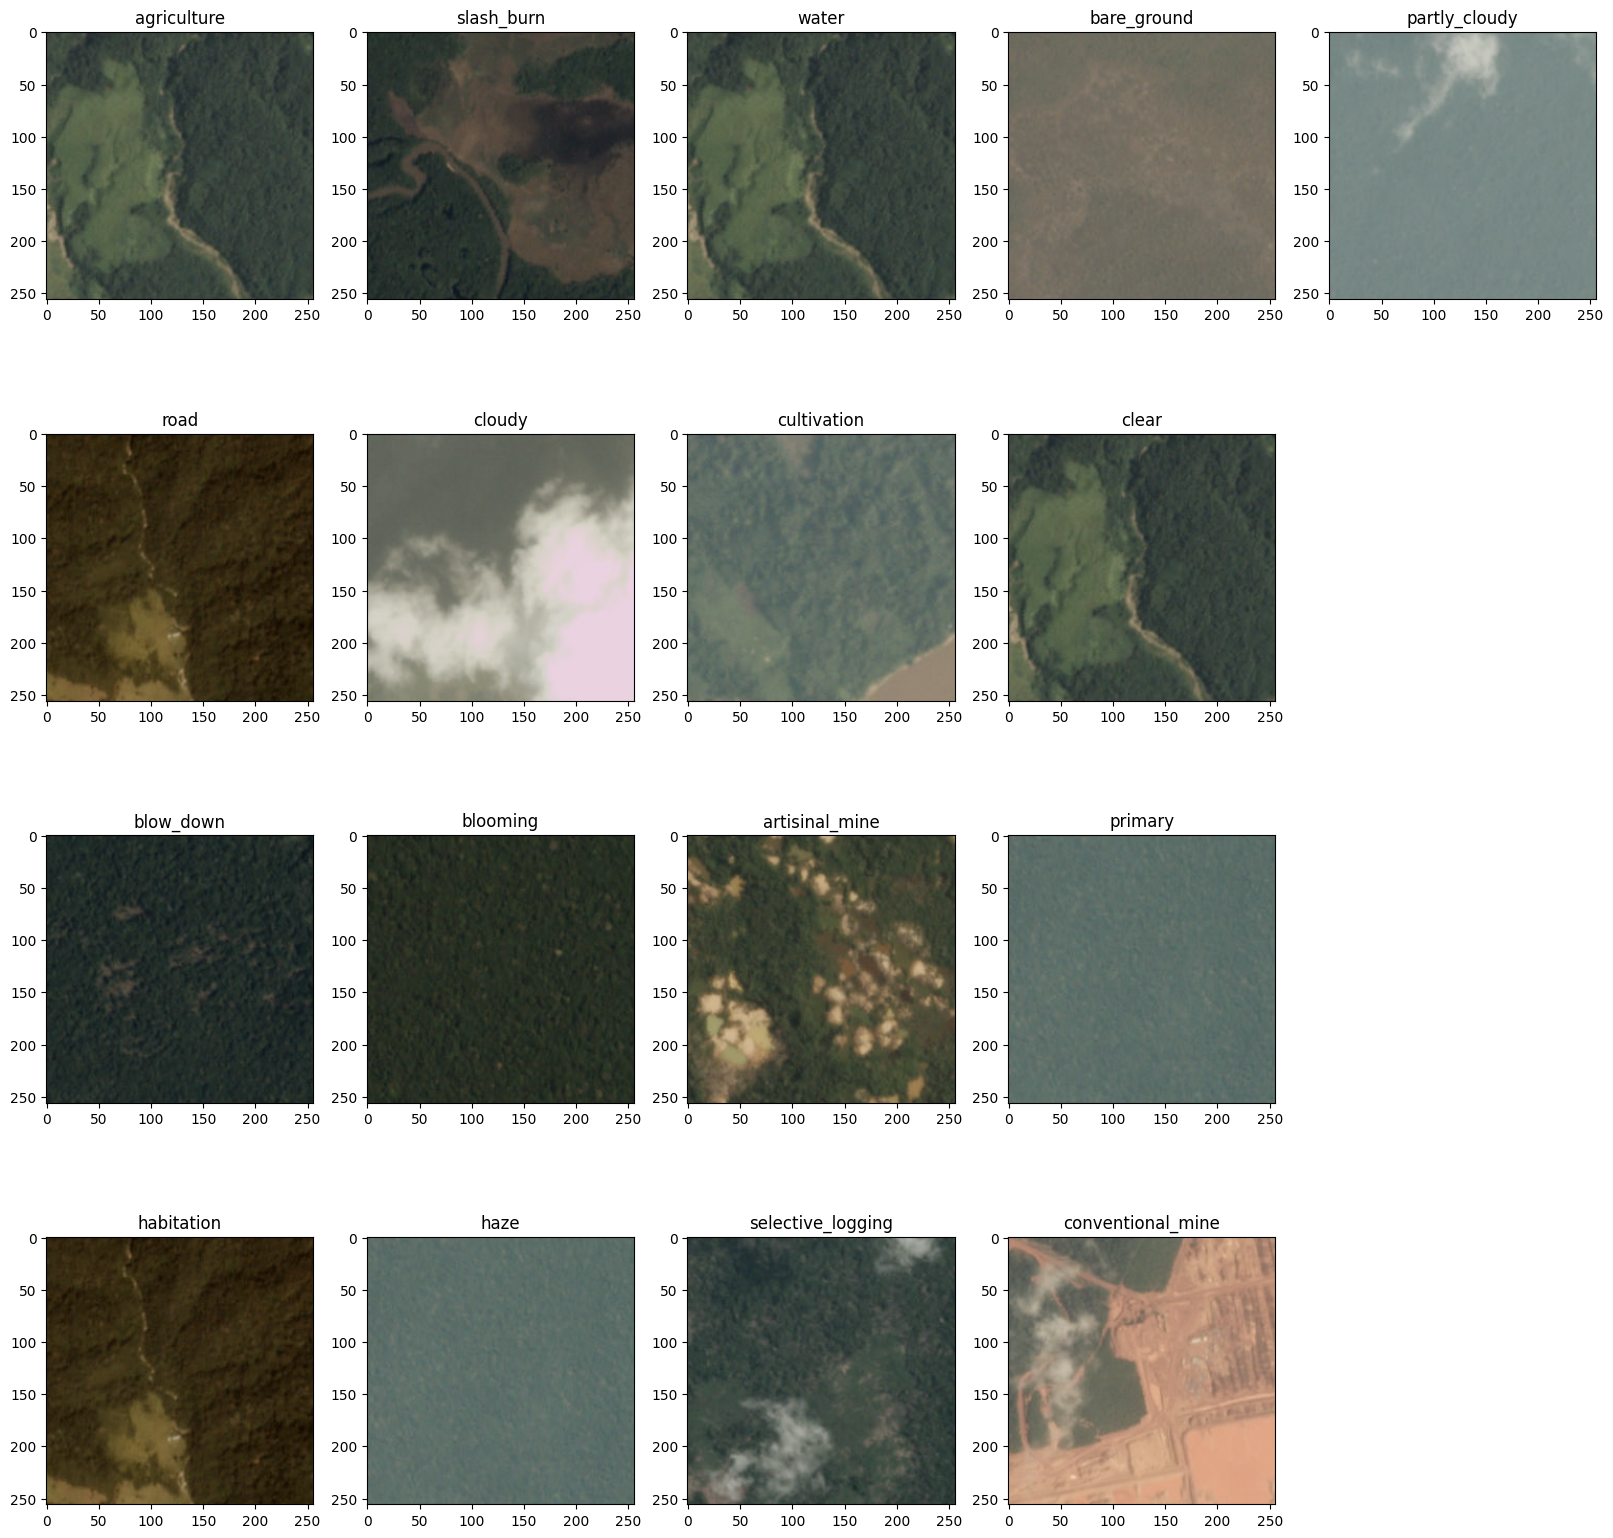

In [11]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

In [12]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = rnf.get_data(df_train, df_val, path_train)

imgs, labels = next(iter(dl_train))

c:\Users\hanna\Documents\GitHub\msc_thesis\Notebooks\resnet18_funcs.py:125: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)



In [13]:
idx_fold =  0
if os.path.exists(f'train_results_fold{idx_fold}.pkl'):
        with open(f'train_results_fold{idx_fold}.pkl','rb') as f:
            train_results = pickle.load(f)
        model = torch.load(f"resnet18_fold{idx_fold}.pth")

else:
    
    model, train_results = rnf.train_model(dl_train, dl_val, idx_fold)
    torch.save(model, f"resnet18_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

In [14]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

In [15]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

threshs = rnf.find_best_thresholds(Y_hat_val, Y_val)

  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.12, 0.16, 0.18, 0.33, 0.25, 0.14, 0.09, 0.15, 0.27, 0.16, 0.08, 0.16, 0.18, 0.25, 0.29, 0.07, 0.19] -- best score: 0.9290440499774747


In [16]:
tstpth = "C:/Users/hanna/Documents/EPA/scriptie/planet-understanding-the-amazon-from-space/"

path_test_table = tstpth + "train_v2.csv/train_v2.csv"
path_test_file_1 = "C:/Users/hanna/Documents/EPA/scriptie/large_sat_img/tiles_256/"
path_test_file_2 = tstpth + "test-jpg-additional"
file_count = len(os.listdir(path_test_file_1))
df_test = pd.read_csv(os.path.join(tstpth, "sample_submission_v2/sample_submission_v2.csv"))

In [17]:
# if os.path.exists(f'yhattest.pkl'):
#         with open(f'yhattest.pkl','rb') as f:
#             Y_hat_test = pickle.load(f)

# else:

#     Y_hat_test = []
#     for idx_tta in range(6):
#         Y_hat_test_tta = []
#         dl_test, df_test = rnf.get_data(idx_tta, df_test, path_test_file_1)
#         for X, _ in tqdm(dl_test):
#             Y_hat_test_batch = rnf.batch_predict(model, X)
#             Y_hat_test_tta.extend(Y_hat_test_batch)
#         Y_hat_test.append(Y_hat_test_tta)

#     Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
#     Y_hat_test = (Y_hat_test > threshs).astype(float)
#     with open(f'yhattest.pkl','wb') as f:
#         pickle.dump(Y_hat_test, f)

# def get_data(df_train, df_val, path_train):


In [18]:
# Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
# test_tags = []
# for row in Y_hat_test_inv:
#     tags = " ".join(row)
#     test_tags.append(tags)

# df_test["tags"] = test_tags
# df_test.to_csv("my_sample_submission.csv", index=False)

In [5]:
from torchvision import transforms as transforms

def infer_transforms(image):
    # Define the torchvision image transforms.
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])
    return transform(image)

In [6]:
import time

In [7]:
idx_fold =  0
if os.path.exists(f'train_results_fold{idx_fold}.pkl'):
        with open(f'train_results_fold{idx_fold}.pkl','rb') as f:
            train_results = pickle.load(f)
        model = torch.load(f"resnet18_fold{idx_fold}.pth")

else:
    
    model, train_results = rnf.train_model(dl_train, dl_val, idx_fold)
    torch.save(model, f"resnet18_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

In [8]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

In [12]:

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)

fig.update_xaxes(title_text='epochs', row=1, col=1)
fig.update_yaxes(title_text='value', row=1, col=1)

fig.update_xaxes(title_text='epochs', row=1, col=2)
fig.update_yaxes(title_text='score', row=1, col=2)

fig.show()

In [24]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

threshs = rnf.find_best_thresholds(Y_hat_val, Y_val)

  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.12, 0.16, 0.18, 0.33, 0.25, 0.14, 0.09, 0.15, 0.27, 0.16, 0.08, 0.16, 0.18, 0.25, 0.29, 0.07, 0.19] -- best score: 0.9290440499774747


In [25]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

In [26]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

In [27]:
pth = 'C:/Users/hanna/Documents/EPA/scriptie/sat_data_correct/juli_aug/tiles_256/*jpg'
test_images =[]
test_images.extend(glob(pth))

start_time = time.time()
outputs_all = []
output_df= pd.DataFrame(columns=['img_name', 'labels'])
# print(output_df)
for i in trange(len(test_images)):
        # Get the image file name for saving output later on.
        image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
        orig_image = cv2.imread(test_images[i])
        frame_height, frame_width, _ = orig_image.shape
        image=orig_image
        # BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = infer_transforms(image)
        # Add batch dimension.
        image = torch.unsqueeze(image, 0)
        with torch.no_grad():
            outputs = model(image.to(device))
            outputs = outputs[0].tolist()
        outputs_all.append(outputs)
        new_record = pd.DataFrame([{'img_name':image_name, 'labels': (np.array(outputs) > threshs).astype(float)}])
        output_df = pd.concat([output_df, new_record], ignore_index=True)


        
end_time = time.time()

  0%|          | 0/10500 [00:00<?, ?it/s]

In [28]:
output_df

img_name                                             labels
0       L15-0603E-1069N_00  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
1       L15-0603E-1069N_01  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...
2      L15-0603E-1069N_010  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
3      L15-0603E-1069N_011  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
4      L15-0603E-1069N_012  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
...                    ...                                                ...
10495   L15-0608E-1075N_95  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
10496   L15-0608E-1075N_96  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...
10497   L15-0608E-1075N_97  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...
10498   L15-0608E-1075N_98  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...
10499   L15-0608E-1075N_99  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...

[10500 rows x 2 columns]

In [29]:
with open(f'outputs_test.pkl','wb') as f:
    pickle.dump(outputs_all, f)

In [30]:
outputs_mean = np.mean(np.array(outputs_all), axis=0)
outputs_thres = (np.array(outputs_all) > threshs).astype(float)

In [31]:
output_df.iloc[0]

img_name                                   L15-0603E-1069N_00
labels      [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
Name: 0, dtype: object

In [32]:
Y_hat_test_inv = encoder.inverse_transform(outputs_thres)
test_tags = []
count = 0
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)
    output_df.iloc[count]['labels'] =tags
    count+=1
output_df.to_csv("results_resnet18.csv", index=False)

In [58]:
df_class

image_name                                           tags  \
0          train_0                                   haze primary   
1          train_1                agriculture clear primary water   
2          train_2                                  clear primary   
3          train_3                                  clear primary   
4          train_4      agriculture clear habitation primary road   
...            ...                                            ...   
40474  train_40474                                  clear primary   
40475  train_40475                                         cloudy   
40476  train_40476                      agriculture clear primary   
40477  train_40477                 agriculture clear primary road   
40478  train_40478  agriculture cultivation partly_cloudy primary   

                                               list_tags  
0                                        [haze, primary]  
1                   [agriculture, clear, primary, water]  
2                                       [clear, primary]  
3                                       [clear, primary]  
4        [agriculture, clear, habitation, primary, road]  
...                                                  ...  
40474                                   [clear, primary]  
40475                                           [cloudy]  
40476                      [agriculture, clear, primary]  
40477                [agriculture, clear, primary, road]  
40478  [agriculture, cultivation, partly_cloudy, prim...  

[40479 rows x 3 columns]

In [60]:
output_df["list_tags"] = output_df.labels.str.split(" ")
row_tags = output_df.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

In [61]:
fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.show()

In [39]:
new_output_df = output_df[output_df['labels'].str.contains("cultivation")]

In [56]:
new_output_df = output_df[output_df['labels'].str.contains("habitation")]

In [48]:
new_output_df

img_name                                             labels
1       L15-0603E-1069N_01    agriculture clear cultivation haze primary road
9       L15-0603E-1069N_03  agriculture clear cultivation habitation haze ...
16      L15-0603E-1069N_10  agriculture clear cultivation habitation haze ...
18     L15-0603E-1069N_101              agriculture clear cultivation primary
25     L15-0603E-1069N_102         agriculture clear cultivation primary road
...                    ...                                                ...
10489  L15-0608E-1075N_913   agriculture clear cultivation haze primary water
10495   L15-0608E-1075N_95         agriculture cultivation haze primary water
10496   L15-0608E-1075N_96  agriculture clear cultivation habitation haze ...
10497   L15-0608E-1075N_97  agriculture clear cultivation habitation haze ...
10498   L15-0608E-1075N_98  agriculture clear cultivation habitation haze ...

[3641 rows x 2 columns]

In [51]:
len(all_tags)

12

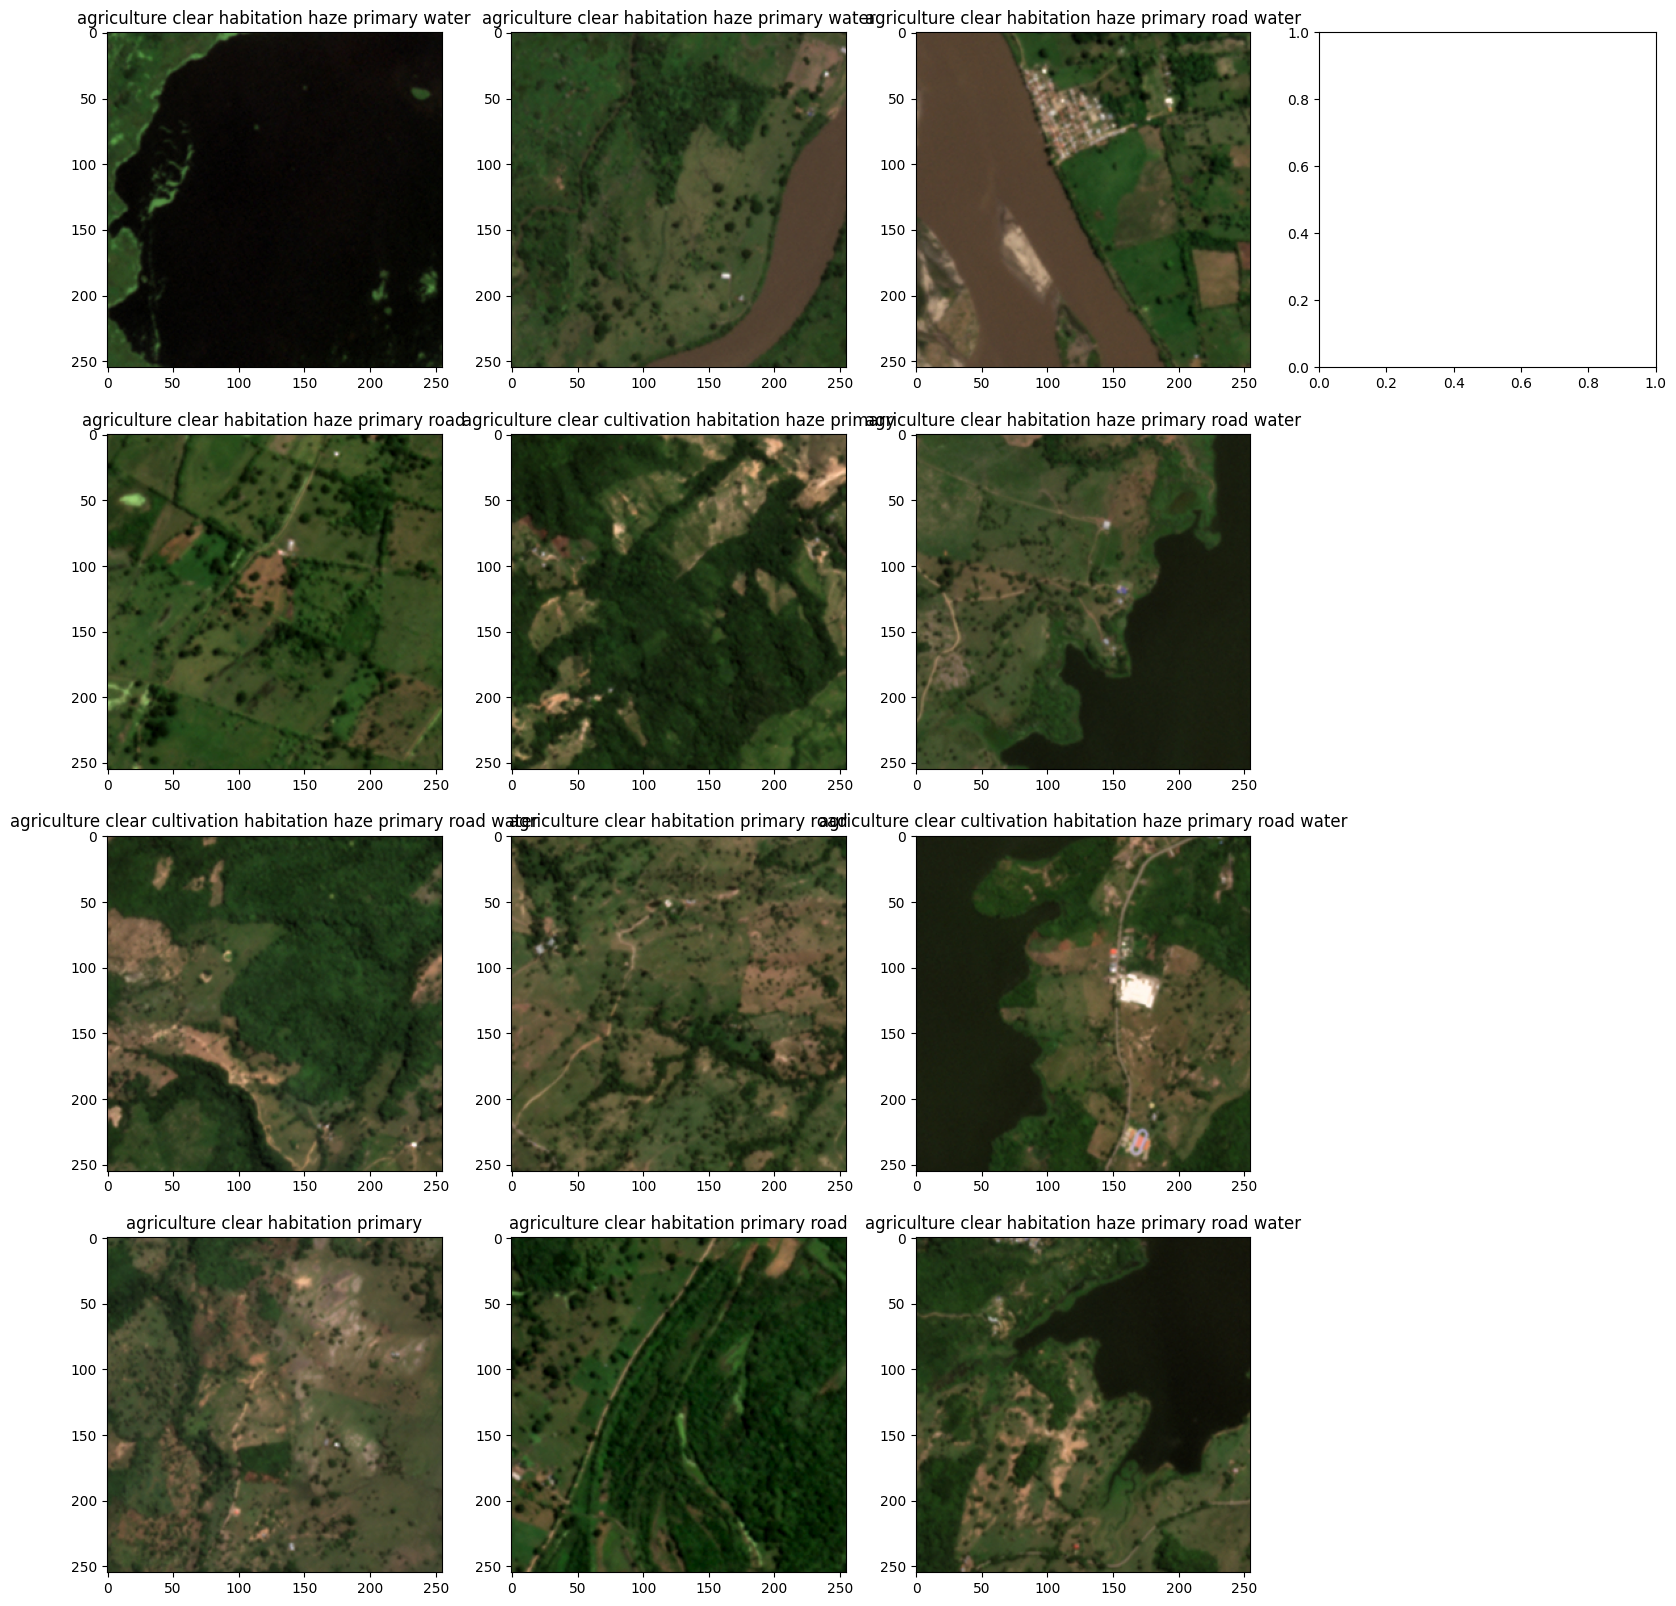

In [57]:
path_test= 'C:/Users/hanna/Documents/EPA/scriptie/sat_data_correct/juli_aug/tiles_256/'
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]

# all_tags = ['habitation', 'cultivation', 'habitation', 'cultivation']
# N_tags = len(all_tags)
N_tags = 16
all_tags = new_output_df[:12].index.to_list()
fig, axes = plt.subplots(4, 4, figsize=(20, 20)) #(N_tags//4+1)
# for idx, tag in enumerate(all_tags):
#     filename = output_df.loc[output_df.labels.str.contains(tag)].img_name.values[0]
for idx, tag in enumerate(all_tags):
    filename = output_df.loc[tag].img_name
    img = cv2.imread(os.path.join(path_test, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(output_df.loc[tag].labels)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

In [46]:
#plot cultivation labels

In [ ]:
tags

'agriculture clear habitation haze primary road water'

In [ ]:
encoder

MultiLabelBinarizer()

In [ ]:
outputs_thres

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [ ]:
outputs_mean

array([7.44176114e-01, 8.48026802e-04, 2.32566076e-02, 1.02322841e-03,
       1.20351753e-03, 6.77236751e-01, 8.87597142e-03, 7.61813167e-04,
       2.26183115e-01, 1.97669027e-01, 3.65008673e-01, 4.85612744e-03,
       9.44500107e-01, 4.53129515e-01, 3.11799587e-03, 4.30210017e-03,
       3.15516641e-01])

In [ ]:
outputs_arr = np.array(outputs_all)

In [ ]:
np.mean(outputs_arr, axis=1)

array([0.25123762, 0.25331752, 0.23525247, ..., 0.30256456, 0.36157479,
       0.28638595])

In [ ]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = rnf.get_data(idx_tta, df_test, file_count, path_test_file_1, None)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = rnf.batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)

Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)


TypeError: get_data() takes 3 positional arguments but 5 were given

In [ ]:
Y_hat_test = []
for idx_tta in range(6):
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = rnf.batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)


In [ ]:
#TODO:
#create one large dem
#select relevant points